# San Francisco Working Families Credit

Analysis of [eligibility criteria](https://www.sfhsa.org/services/jobs-money/working-families-credit-wfc-program/eligibility-wfc) for the San Francisco Working Families Credit:

> * Have never received the WFC before
* Have earned less than $53,930 in 2017
* Have filed your tax return by April 17 deadline
* Claim the Earned Income Tax Credit (EITC) on your federal income tax return (see table below for more information)
* Claim at least one qualifying dependent child on your federal income tax return
* Live in San Francisco

The income limit of \$53,930 is redundant with the EITC claiming, as this is the maximum AGI to claim the EITC, [per IRS guidelines](https://www.irs.gov/credits-deductions/individuals/earned-income-tax-credit/eitc-income-limits-maximum-credit-amounts).

This notebook uses national CPS data to estimate the share of all EITC filers that have a qualifying dependent child.

While these criteria concern 2017 thresholds, this analysis uses 2018 data and tax logic, as any reforms would be for the 2018 tax year (early 2019).

*Data: CPS  |  Tax year: 2018  |  Type: Static  |  Author: Max Ghenis  |  Date run: 2018-03-08*

## Setup

### Imports

In [50]:
import taxcalc as tc
import pandas as pd
import numpy as np
import copy
from bokeh.io import show, output_notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# On Python 3.6 use "import urllib.request as url_lib".
import urllib as url_lib

In [51]:
tc.__version__

'0.17.0'

### Configuration

In [52]:
sns.set_style('white')
DPI = 300
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi']= DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [53]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [54]:
# Show one decimal in tables.
pd.set_option('precision', 2)

### Constants

In [55]:
WFC_INC_C = 53930

## Data

Generate data using Tax-Calculator.

In [56]:
recs = tc.Records.cps_constructor()

In [57]:
calc = tc.Calculator(records=recs, policy=tc.Policy(), verbose=False)
calc.advance_to_year(2018)
calc.calc_all()

In [58]:
df = calc.dataframe([
    's006', 'aftertax_income', 'XTOT', 'nu18',
    'EIC',  # Children eligible for EITC.
    'eitc',  # EITC amount.
    'c00100',  # AGI, used for EITC threshold.
    # Include non-cash benefits to subtract for cash income.
    # Vet and other benefits have some cash components, but unclear how much.
    'snap_ben', 'mcaid_ben', 'mcare_ben', 'vet_ben', 'other_ben'])

Flags for WFC.

In [59]:
df['has_EIC'] = df.EIC > 0

Summed variables.

In [93]:
df['s006_m'] = df.s006 / 1e6
df['XTOT_m'] = df.XTOT * df.s006_m
df['nu18_m'] = df.nu18 * df.s006_m
df['EIC_m'] = df.EIC * df.s006_m
df['eitc_m'] = df.eitc * df.s006_m
df['afti_m'] = df.aftertax_income * df.s006_m
df['afti_round'] = 10000 * (df.aftertax_income / 10000).round()

Limit to EITC recipients and compute shares of tax units and people.

In [61]:
eitcr = df[df.eitc > 0].copy()  # Avoids warning.
eitcr.s006_share = 100 * eitcr.s006 / eitcr.s006.sum()
eitcr.XTOT_share = 100 * eitcr.XTOT_m / eitcr.XTOT_m.sum()

/usr/local/google/home/mghenis/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/usr/local/google/home/mghenis/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


## Current policy

## Exploratory

### People per tax unit by household income

In [94]:
xtot_per_tu = df.groupby('afti_round')[['XTOT_m', 's006_m']].sum()

In [95]:
xtot_per_tu['xtot_per_tu'] = xtot_per_tu.XTOT_m / xtot_per_tu.s006_m

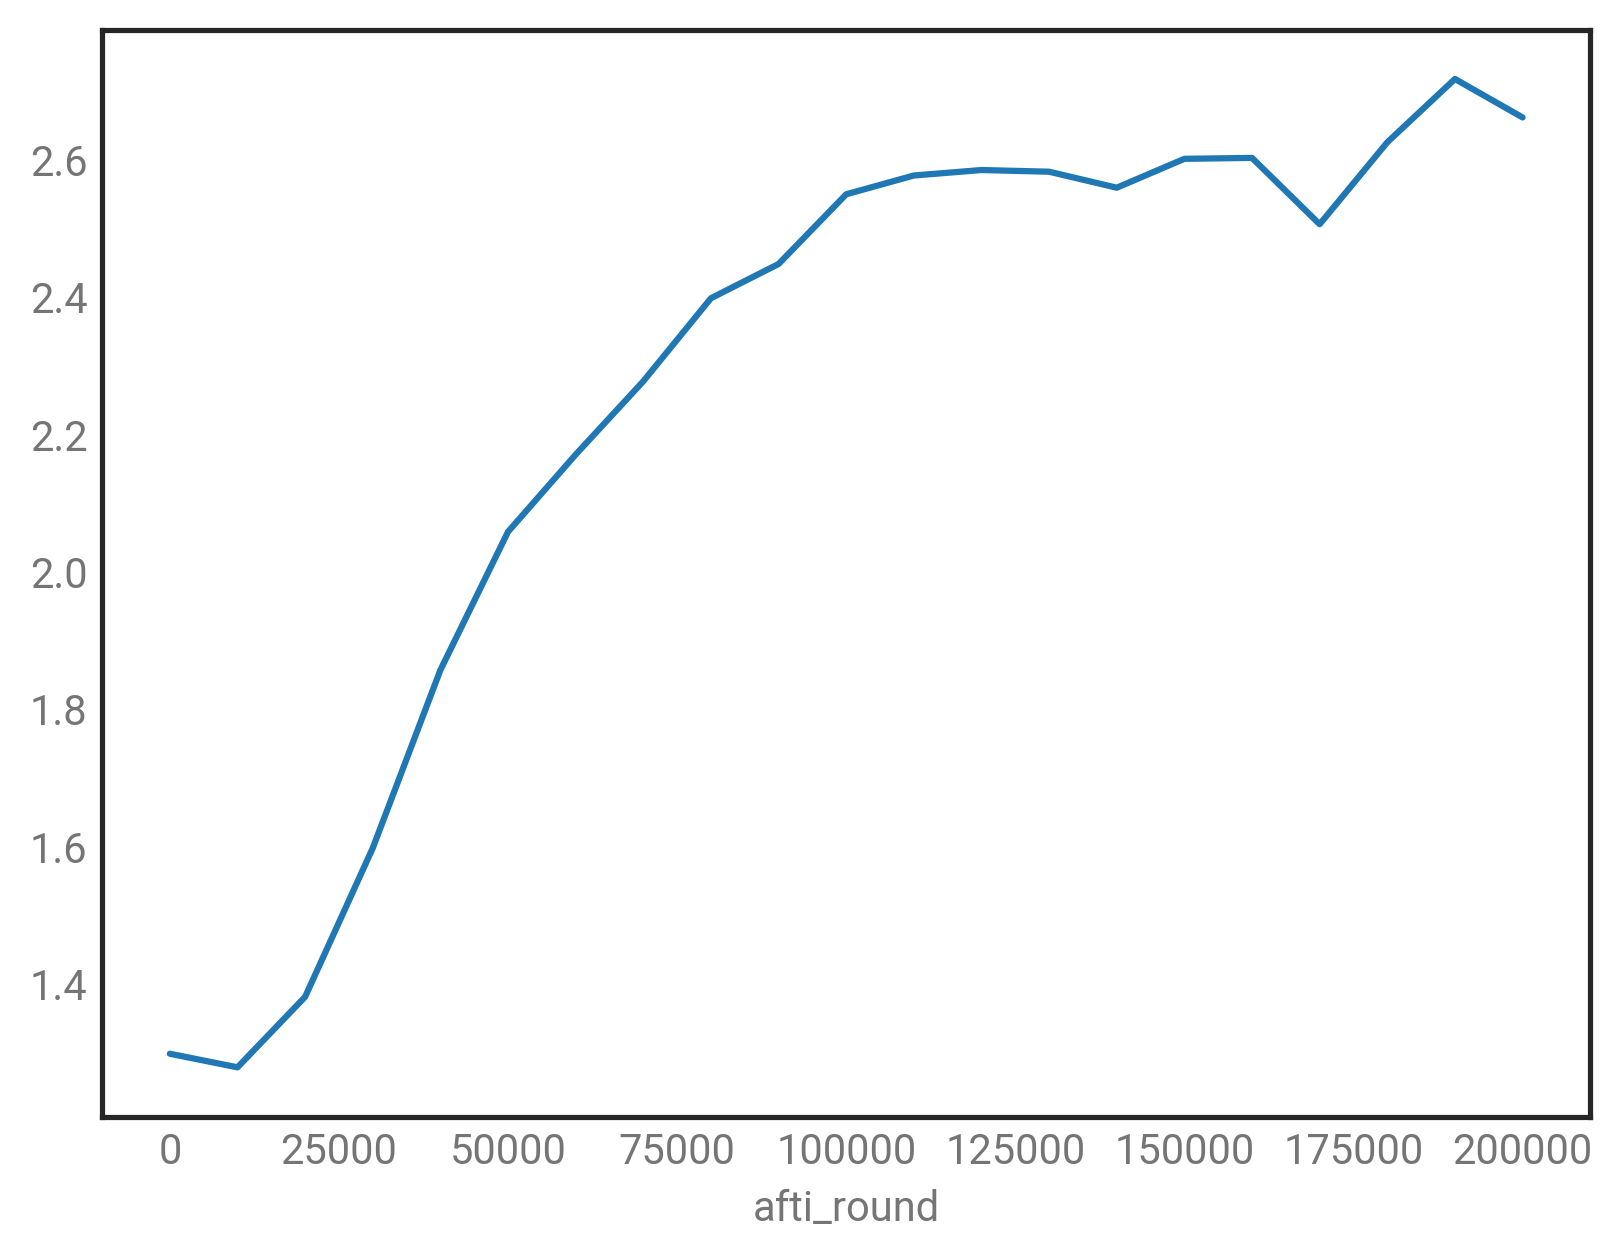

In [96]:
xtot_per_tu.loc[10000 * np.arange(0, 21), 'xtot_per_tu'].plot()
plt.show()

In [97]:
xtot_per_tu_u50k = df.loc[df.aftertax_income <= 50000, 
                          ['s006_m', 'XTOT_m']].sum()
round(xtot_per_tu_u50k.XTOT_m / xtot_per_tu_u50k.s006_m, 2)

1.56

In [98]:
xtot_per_tu_o50k = df.loc[df.aftertax_income > 50000, 
                          ['s006_m', 'XTOT_m']].sum()
round(xtot_per_tu_o50k.XTOT_m / xtot_per_tu_o50k.s006_m, 2)

2.42

### Children per tax unit by household income

In [69]:
df_u18 = df[df.nu18 > 0].copy()

In [75]:
u18_per_tu = df_u18.groupby('afti_round')[['nu18_m', 's006_m']].sum()

In [76]:
u18_per_tu['nu18_per_tu'] = u18_per_tu.nu18_m / u18_per_tu.s006_m

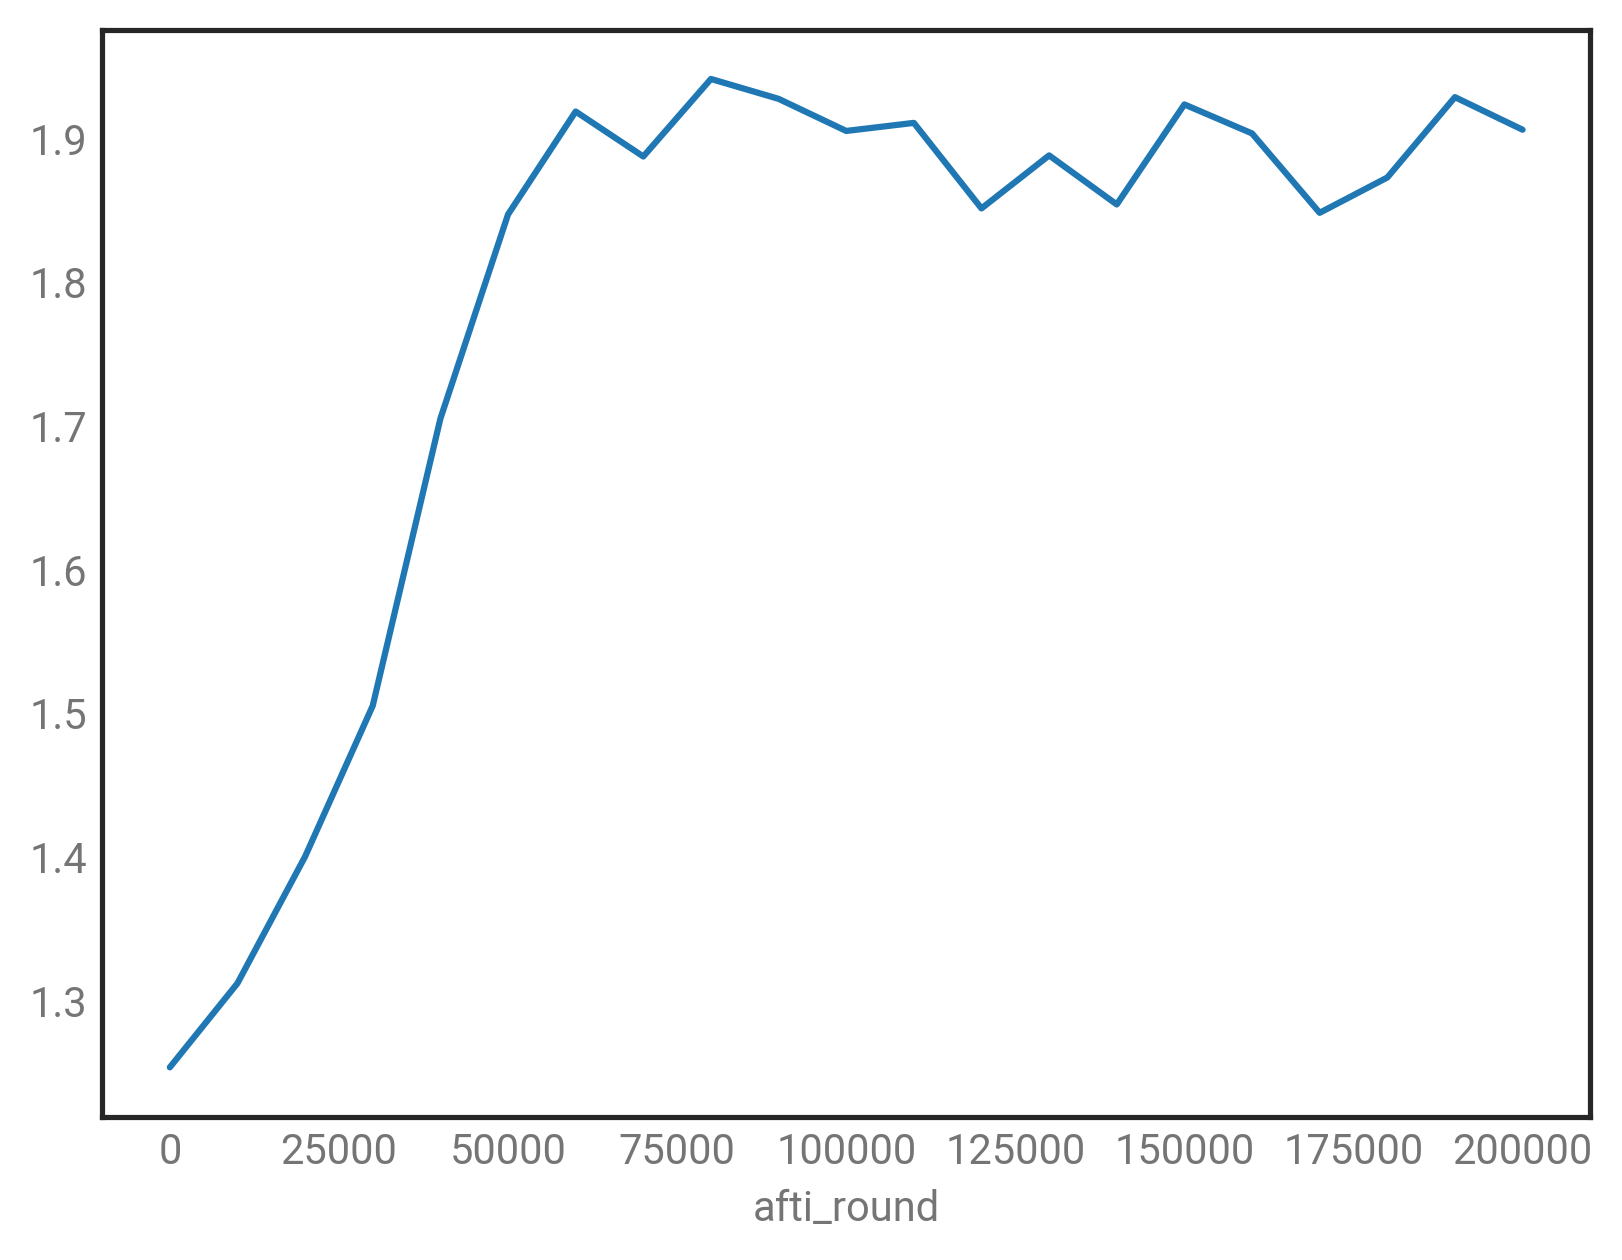

In [87]:
u18_per_tu.loc[10000 * np.arange(0, 21), 'nu18_per_tu'].plot()
plt.show()

In [91]:
nu18_per_tu_u50k = df_u18.loc[df_u18.aftertax_income <= 50000, 
                              ['s006_m', 'nu18_m']].sum()
round(nu18_per_tu_u50k.nu18_m / nu18_per_tu_u50k.s006_m, 2)

1.53

In [92]:
nu18_per_tu_o50k = df_u18.loc[df_u18.aftertax_income > 50000, 
                              ['s006_m', 'nu18_m']].sum()
round(nu18_per_tu_o50k.nu18_m / nu18_per_tu_o50k.s006_m, 2)

1.9

## Reforms

### Removing dependent restriction

Average EITC amount per tax unit and per person.

In [63]:
by_has_eitc = eitcr.groupby(['has_EIC'])['s006_m', 'XTOT_m', 'eitc_m'].sum()
by_has_eitc['avg_eitc'] = by_has_eitc.eitc_m / by_has_eitc.s006_m
by_has_eitc['avg_eitc_pp'] = by_has_eitc.eitc_m / by_has_eitc.XTOT_m
by_has_eitc

,s006_m,XTOT_m,eitc_m,avg_eitc,avg_eitc_pp
has_EIC,,,,,
False,5.97,8.99,1780.96,298.25,198.19
True,19.09,54.63,57777.67,3026.85,1057.53


### Change to \$125 per person

In [33]:
by_has_eitc['people_per_tax_unit'] = by_has_eitc.XTOT_m / by_has_eitc.s006_m

In [34]:
by_has_eitc.people_per_tax_unit / 2

has_EIC
False    0.75
True     1.43
Name: people_per_tax_unit, dtype: float64

Shows that this would cost an additional 43%.

### Top up to 10% of the federal EITC

In [36]:
eitcr['wfc_m'] = 250 * eitcr.s006 / 1e6
eitcr['top_up_wfc'] = np.where(eitcr.eitc > 2500, eitcr.eitc / 10, 250)
eitcr['top_up_wfc_m'] = eitcr.top_up_wfc * eitcr.s006 / 1e6

In [18]:
eitcr.groupby('has_EIC')[['wfc_m', 'top_up_wfc_m']].sum()

,wfc_m,top_up_wfc_m
has_EIC,,
False,1492.83,1492.83
True,4772.09,6621.82


### Include households with zero AGI

In [40]:
round(df.loc[df.has_EIC & (df.c00100 == 0), 's006'].sum())

3022.0

### Universal child benefit

In [48]:
SF_POP = 871000
SF_U18_SHARE = 0.14
sf_u18 = SF_POP * SF_U18_SHARE
child_benefit_cost = 250 * sf_u18
round(child_benefit_cost / 1e6)

30.0

### \$250 for all tax units with children

Divide child population by the average number of children per tax unit with children.

In [47]:
child_tus = df[df.nu18 > 0].s006_m.sum()
children_per_child_tu = df.nu18_m.sum() / child_tus

child_benefit_cost / children_per_child_tu

17453271.041496519

In [49]:
sf_u18 / children_per_child_tu

69813.084165986074

## Census

Compare San Francisco to US overall.

Variables are described [here](https://api.census.gov/data/2016/acs/acs1/profile/variables.html).

Income and benefits [appear to include](http://webapp1.dlib.indiana.edu/virtual_disk_library/index.cgi/4291881/FID1867/acs_html/html/meth_doc/datadef/income2.htm) cash benefits only, e.g. SSDI and TANF, but
not SNAP.

In [20]:
from census import Census
from us import states

In [39]:
CENSUS_KEY = 'd6ae38c07a1b52d139c729945d7c88ea266806b1'
c = Census(CENSUS_KEY)

In [40]:
SF_FIPS = '075'

In [41]:
# Map to floor.
# % of households in each income category.
INCOME_MAP = dict([('DP03_0052PE', 0), 
                   ('DP03_0053PE', 10000),
                   ('DP03_0054PE', 15000),
                   ('DP03_0055PE', 25000),
                   ('DP03_0056PE', 35000),
                   ('DP03_0057PE', 50000),
                   ('DP03_0058PE', 75000),
                   ('DP03_0059PE', 100000),
                   ('DP03_0060PE', 150000),
                   ('DP03_0061PE', 200000)])
# pd.DataFrame.from_dict throws error about index.
INCOME_MAP_DF = pd.DataFrame(pd.Series(INCOME_MAP))
INCOME_MAP_DF.columns = ['min']
# Add maximum.
INCOME_MAP_DF['max'] = (
    INCOME_MAP_DF.iloc[1:]['min'].append(
        pd.Series([9e9])).reset_index(drop=True) - 1).tolist()
INCOME_MAP_DF

,min,max
DP03_0052PE,0,1.00e+04
DP03_0053PE,10000,1.50e+04
DP03_0054PE,15000,2.50e+04
DP03_0055PE,25000,3.50e+04
DP03_0056PE,35000,5.00e+04
DP03_0057PE,50000,7.50e+04
DP03_0058PE,75000,1.00e+05
DP03_0059PE,100000,1.50e+05
DP03_0060PE,150000,2.00e+05
DP03_0061PE,200000,9.00e+09


In [42]:
ACS_VARS = np.append(INCOME_MAP_DF.index, 
                     ['DP03_0062E', 'DP03_0063E',  # Median & mean income.
                      'DP02_0015E']).tolist()

In [43]:
# Returns a one-item list containing a dictionary.
us_acs = c.acs1dp.us(ACS_VARS)[0]
sf_acs = c.acs1dp.state_county(ACS_VARS, states.CA.fips, SF_FIPS)[0]

### Household size

In [46]:
us_acs.get('DP02_0015E')

2.65

In [45]:
sf_acs.get('DP02_0015E')

2.37

### Income

In [48]:
us_inc = pd.merge(pd.DataFrame({'pct': pd.Series(us_acs)}),
                  INCOME_MAP_DF, left_index=True, right_index=True)
# Remove final element, which isn't useful.
us_inc = us_inc.iloc[:len(us_inc) - 1]
us_inc['pct_cumsum'] = us_inc['pct'].cumsum()
# Add median as another data point.
us_median = pd.DataFrame({'pct_cumsum': [50], 
                          'max': us_acs.get('DP03_0062E')})
us_inc = us_inc.append(us_median)
us_inc.sort_values(by='pct_cumsum', inplace=True)

Same for SF.

TODO: Make a function to avoid code duplication.

In [49]:
sf_inc = pd.merge(pd.DataFrame({'pct': pd.Series(sf_acs)}),
                  INCOME_MAP_DF, left_index=True, right_index=True)
# Remove final element, which isn't useful.
sf_inc = sf_inc.iloc[:len(sf_inc) - 1]
sf_inc['pct_cumsum'] = sf_inc['pct'].cumsum()
# Add median as another data point.
sf_median = pd.DataFrame({'pct_cumsum': [50], 
                          'max': sf_acs.get('DP03_0062E')})
sf_inc = sf_inc.append(sf_median)
sf_inc.sort_values(by='pct_cumsum', inplace=True)

In [66]:
us_inc

,max,min,pct,pct_cumsum
DP03_0052PE,9999.0,0.0,6.7,6.7
DP03_0053PE,14999.0,10000.0,4.8,12
DP03_0054PE,24999.0,15000.0,9.7,21
DP03_0055PE,34999.0,25000.0,9.5,31
DP03_0056PE,49999.0,35000.0,13,44
0,57617.0,NaN,NaN,50
DP03_0057PE,74999.0,50000.0,18,61
DP03_0058PE,99999.0,75000.0,12,74
DP03_0059PE,149999.0,100000.0,14,88
DP03_0060PE,199999.0,150000.0,5.8,94


In [51]:
us_inc

,max,min,pct,pct_cumsum
DP03_0052PE,9999.0,0.0,6.7,6.7
DP03_0053PE,14999.0,10000.0,4.8,12
DP03_0054PE,24999.0,15000.0,9.7,21
DP03_0055PE,34999.0,25000.0,9.5,31
DP03_0056PE,49999.0,35000.0,13,44
0,57617.0,NaN,NaN,50
DP03_0057PE,74999.0,50000.0,18,61
DP03_0058PE,99999.0,75000.0,12,74
DP03_0059PE,149999.0,100000.0,14,88
DP03_0060PE,199999.0,150000.0,5.8,94


#### Income CDF

In [52]:
US_COLOR = '#707070'
SF_COLOR = '#FECA00'  # San Francisco flag features yellow.

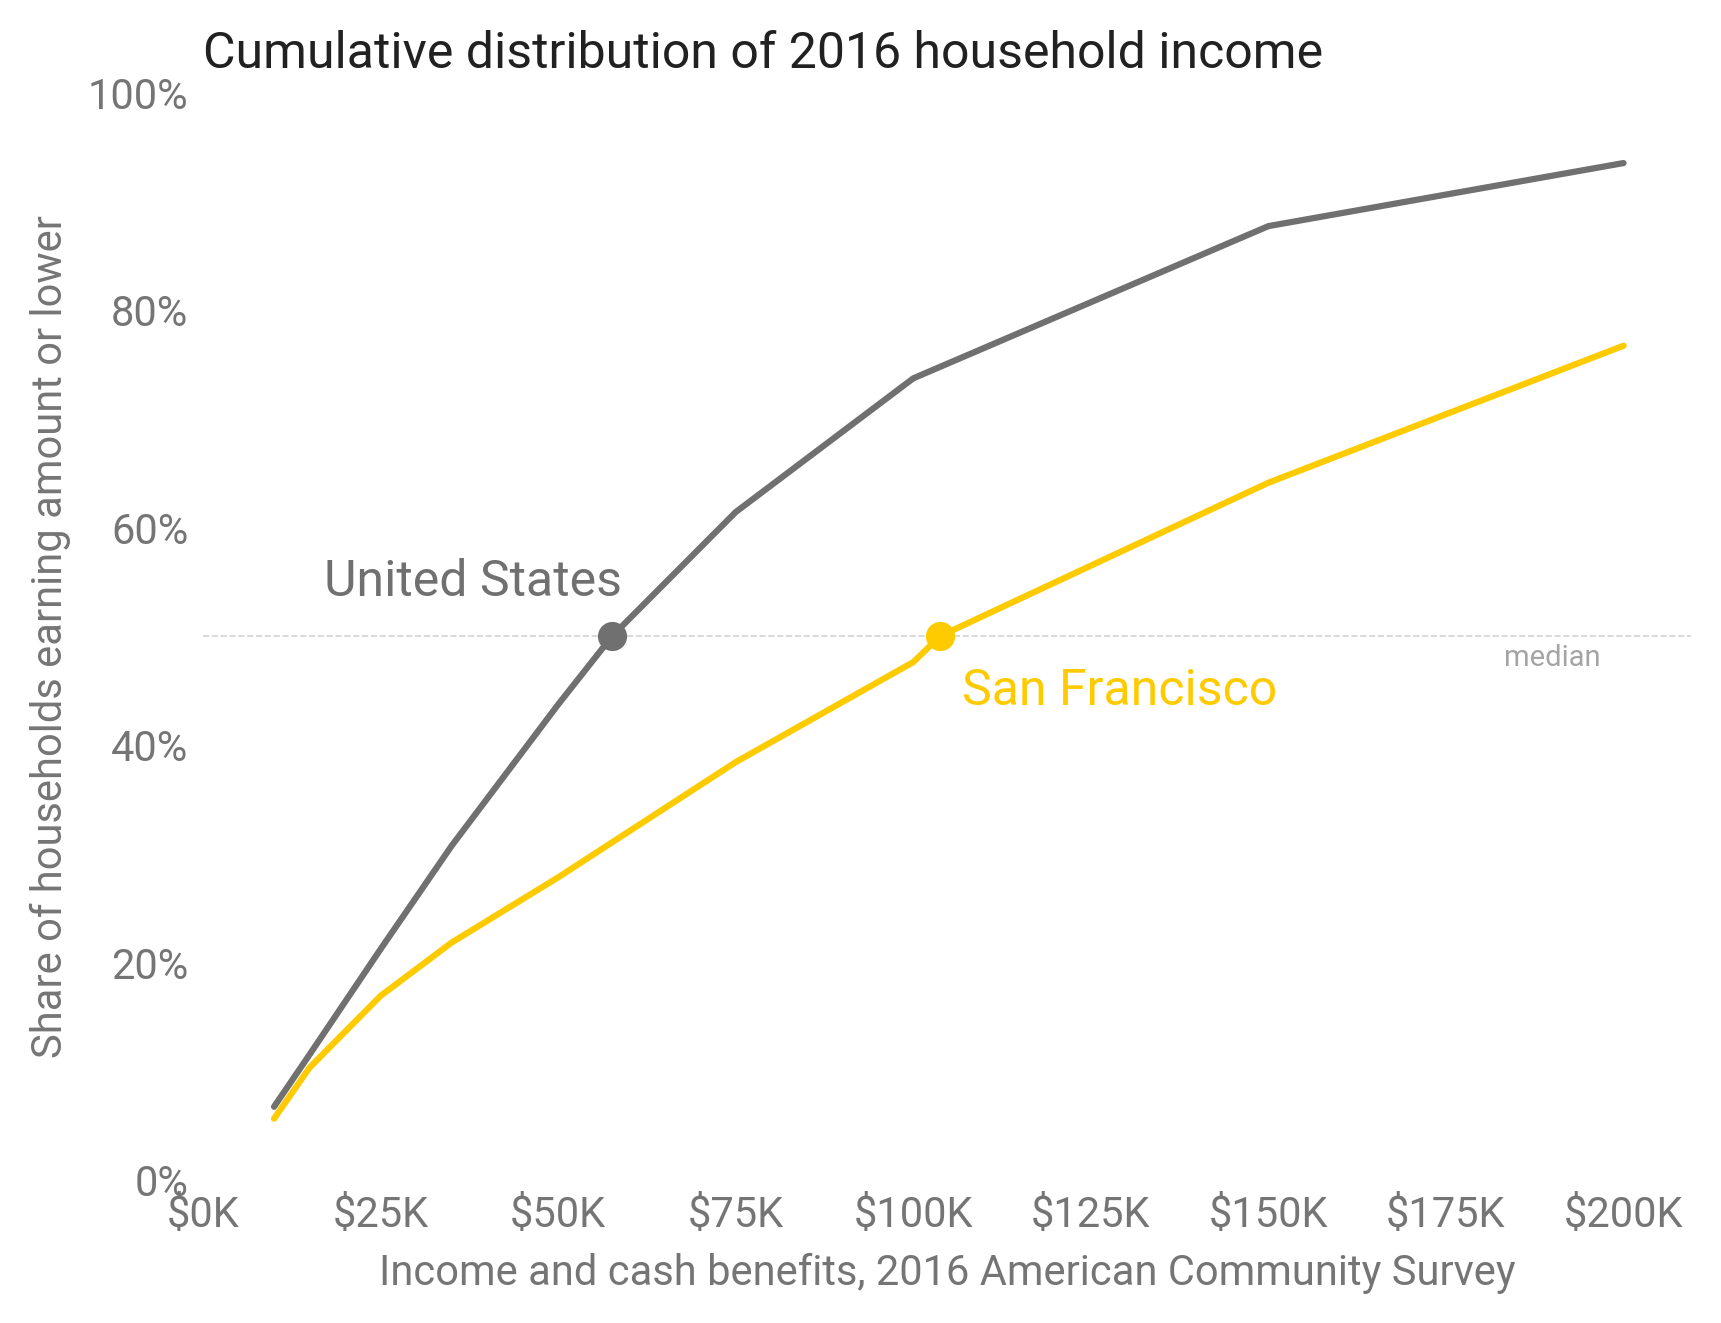

In [53]:
ax = sf_inc.plot(x='max', y='pct_cumsum', color=SF_COLOR)
us_inc.plot(x='max', y='pct_cumsum', color=US_COLOR, ax=ax)
us_median.plot(x='max', y='pct_cumsum', marker='o', color=US_COLOR, ax=ax)
sf_median.plot(x='max', y='pct_cumsum', marker='o', color=SF_COLOR, ax=ax)
# plt.plot(sf_us.loc[sf_us['geo'] == 'SF', 'DP03_0062E'], 50, marker='o',
#          color=SF_COLOR)
# median.plot(x=[50], y=['sf', 'us'], marker='o', ax=ax)
ax.legend_.remove()
# ax.legend(['San Francisco', 'United States'])
ax.text(38000, 55, 'United States', horizontalalignment='center', 
        verticalalignment='center', color=US_COLOR, size=12)
ax.text(129000, 45, 'San Francisco', horizontalalignment='center', 
        verticalalignment='center', color=SF_COLOR, size=12)
plt.axhline(y=50, c='lightgray', linestyle='dashed', linewidth=0.4, zorder=-1)
ax.text(190000, 48, 'median', horizontalalignment='center',
        verticalalignment='center', color='#a4a4a4', size=7)
ax.set(xlabel=
       'Income and cash benefits, 2016 American Community Survey',
       ylabel='Share of households earning amount or lower',
       ylim=(0, 100),
       xlim=0)
sns.despine(left=True, bottom=True)
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x / 1000), ',') + 
                             'K'))
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y / 100)))
plt.title('Cumulative distribution of 2016 household income', 
          loc='left')
plt.show()

#### Limiting to under $50k

In [60]:
us_inc_50k = us_inc[us_inc['max'] < 50000]
us_inc_50k['pct_cumsum'] = (
    100 * us_inc_50k['pct_cumsum'] / us_inc_50k['pct_cumsum'].max())
sf_inc_50k = sf_inc[sf_inc['max'] < 50000]
sf_inc_50k['pct_cumsum'] = (
    100 * sf_inc_50k['pct_cumsum'] / sf_inc_50k['pct_cumsum'].max())

/usr/local/google/home/mghenis/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/google/home/mghenis/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [68]:
us_inc_50k[['max', 'pct_cumsum']]

,max,pct_cumsum
DP03_0052PE,9999.0,15
DP03_0053PE,14999.0,26
DP03_0054PE,24999.0,49
DP03_0055PE,34999.0,70
DP03_0056PE,49999.0,1e+02


In [69]:
sf_inc_50k[['max', 'pct_cumsum']]

,max,pct_cumsum
DP03_0052PE,9999.0,20
DP03_0053PE,14999.0,37
DP03_0054PE,24999.0,61
DP03_0055PE,34999.0,78
DP03_0056PE,49999.0,1e+02


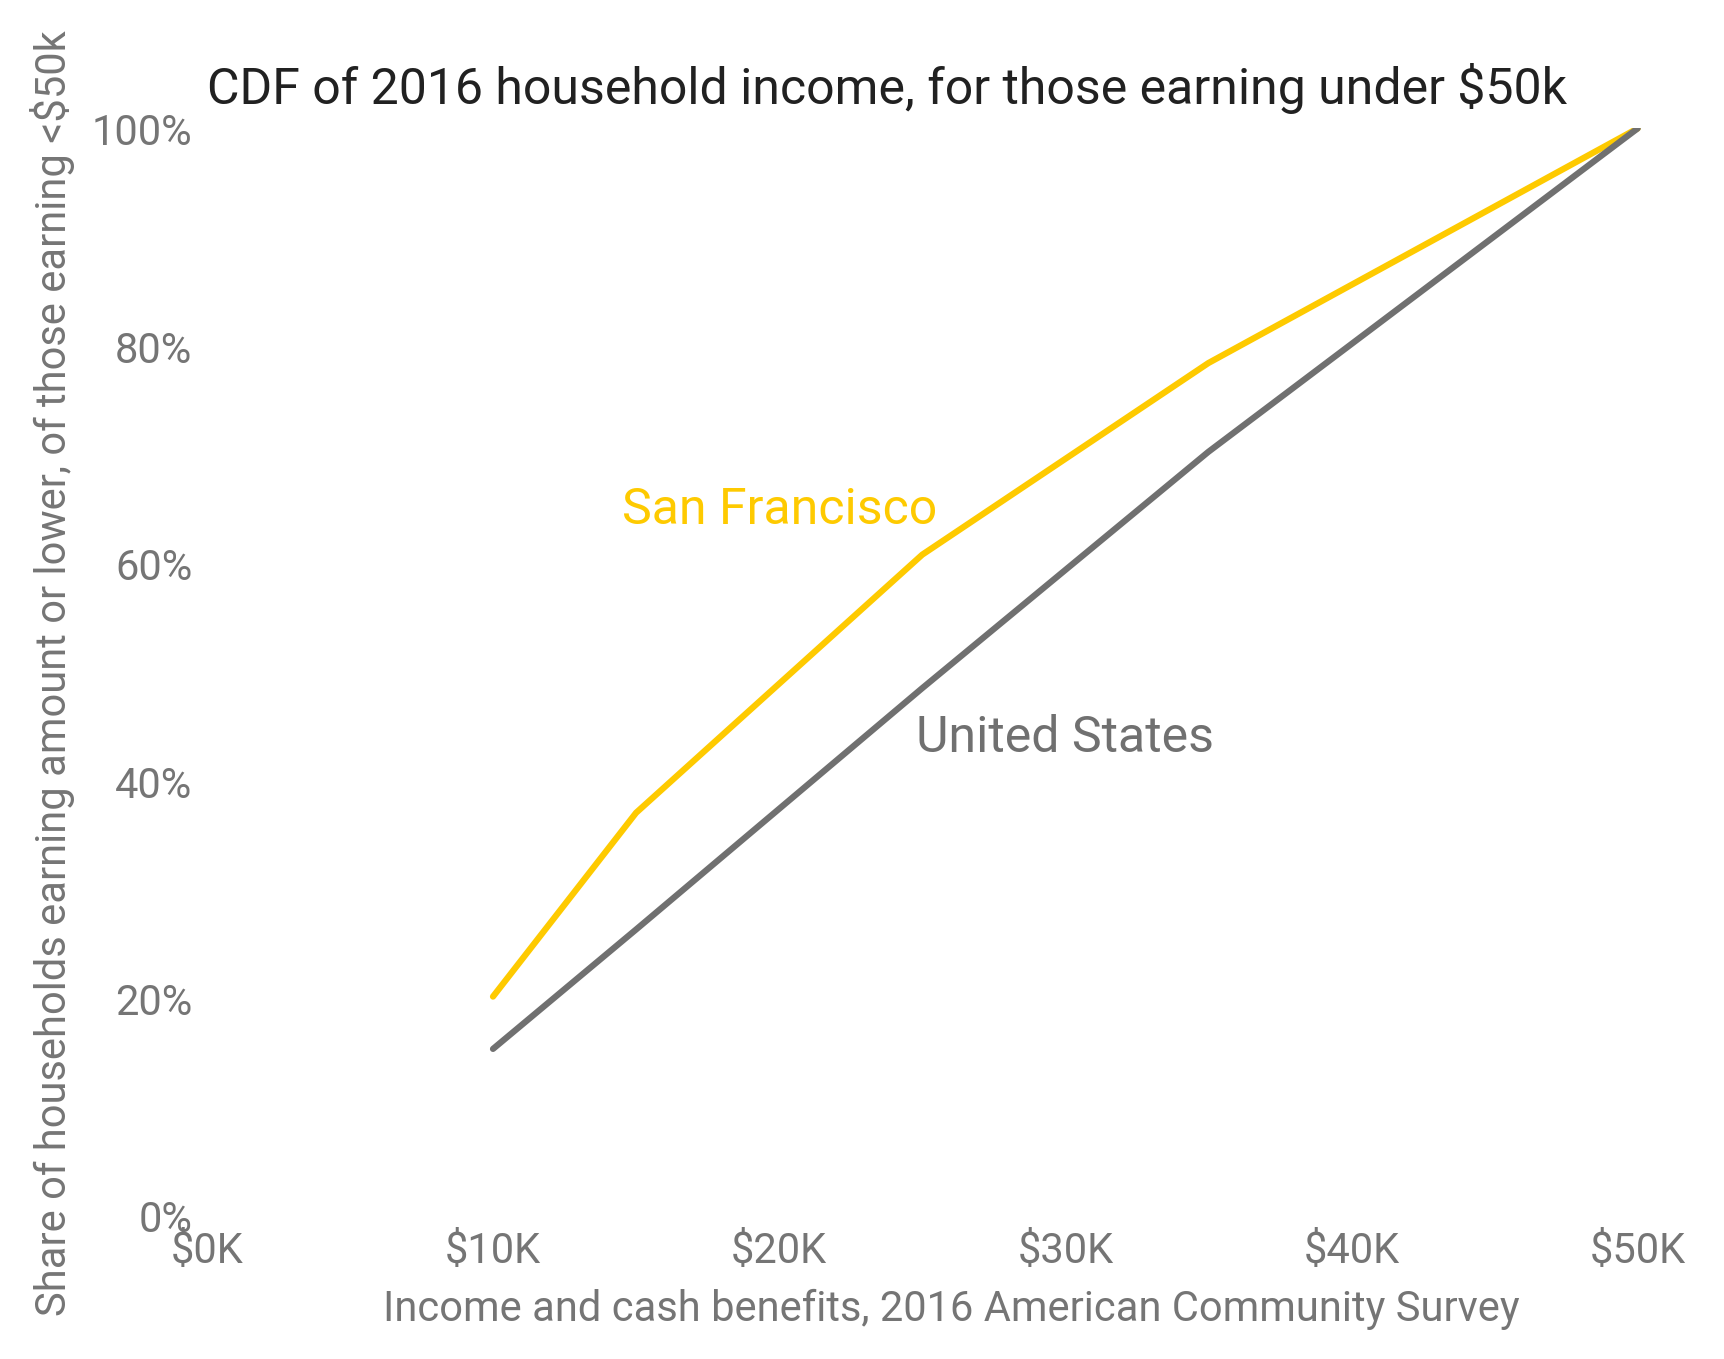

In [65]:
ax = sf_inc_50k.plot(x='max', y='pct_cumsum', color=SF_COLOR)
us_inc_50k.plot(x='max', y='pct_cumsum', color=US_COLOR, ax=ax)
ax.legend_.remove()
# ax.legend(['San Francisco', 'United States'])
ax.text(30000, 44, 'United States', horizontalalignment='center', 
        verticalalignment='center', color=US_COLOR, size=12)
ax.text(20000, 65, 'San Francisco', horizontalalignment='center', 
        verticalalignment='center', color=SF_COLOR, size=12)
ax.set(xlabel=
       'Income and cash benefits, 2016 American Community Survey',
       ylabel='Share of households earning amount or lower,' +
       ' of those earning <$50k',
       ylim=(0, 100),
       xlim=0)
sns.despine(left=True, bottom=True)
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x / 1000), ',') + 
                             'K'))
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y / 100)))
plt.title('CDF of 2016 household income, for those earning under $50k', 
          loc='left')
plt.show()

#### Columns

In [97]:
ax = sf_us_t.plot(x='max', y=['SF', 'US'], kind='bar', 
                  color=[SF_COLOR, US_COLOR])
# ax.legend_.remove()
# # ax.legend(['San Francisco', 'United States'])
# ax.text(55000, 65, 'United States', horizontalalignment='center', 
#         color=US_COLOR, size=12)
# ax.text(130000, 45, 'San Francisco', horizontalalignment='center', 
#         color=SF_COLOR, size=12)
# ax.set(xlabel=
#        'Income and benefits, 2016 American Community Survey',
#        ylabel='Share of households earning amount or lower',
#        ylim=(0, 100),
#        xlim=0)
# sns.despine(left=True, bottom=True)
# ax.get_xaxis().set_major_formatter(
#     mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x / 1000), ',') + 
#                              'K'))
# ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
#     lambda y, _: '{:.0%}'.format(y / 100)))
plt.title('2016 household income buckets', loc='left')
plt.show()

NameError: name 'sf_us_t' is not defined

## Appendix

Tax unit size distribution.

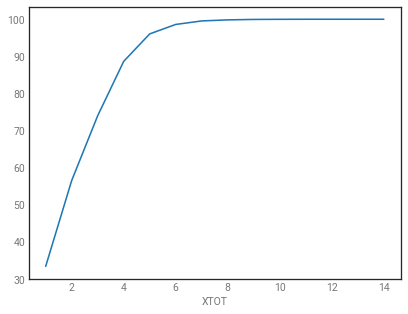

In [51]:
eitcr.groupby('XTOT')['s006_share'].sum().cumsum().plot()
plt.show()

How many get $5k+?

In [47]:
eitcr.loc[eitcr['eitc'] >= 5000, 's006_share'].sum()

12.395280131589635